<a href="https://colab.research.google.com/github/emzu/probabilistic-urban-evolution/blob/main/Footprint_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Score accuracy compared to Ground Truth, Google Buildings dataset
---



Load Google Opean Buildings Footprints Data \\
[Access Data Download](https://colab.research.google.com/github/google-research/google-research/blob/master/building_detection/open_buildings_download_region_polygons.ipynb#scrollTo=qP6ADuzRdZTF) \\
[Dataset Reference](https://sites.research.google/open-buildings/#dataformat) \\
[Dataset Technical Report]() \\

Time-Frame  
  v1: inference carried out during April 2021 on imagery covering 19.4M km2 of Africa.

  v2: inference carried out during August 2022 on imagery covering 39.1M km2 of Africa, South and South-East Asia.

  v3: inference carried out during May 2023 on imagery covering 58M km2 of Africa, South and South-East Asia, Latin America and the Caribbean. See FAQ for comparison of versions.

In [13]:
# Load Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np

### Load Validation Areas

In [5]:
validation_gdf = gpd.read_file("/content/drive/MyDrive/Research/Morphology/Data/Validation Areas/validationAreas (1).shp").to_crs(32736)

In [6]:
#Include Local CLimate Zones
data_lcz = pd.read_csv('/content/drive/MyDrive/Research/Morphology/Data/LCZ_dict.csv', header=None).set_index(0)
LCZ_dict = data_lcz.to_dict(orient='dict')
data_val = pd.read_csv('/content/drive/MyDrive/Research/Morphology/Data/val_areas_lcz.csv').set_index('id')
val_lcz_dict = data_val.to_dict(orient="dict")
val_lcz_dict=val_lcz_dict['lcz']
lcz_rec = []
for id in range(28):
  lcz_rec.append(LCZ_dict[1][val_lcz_dict[id]])

<Axes: >

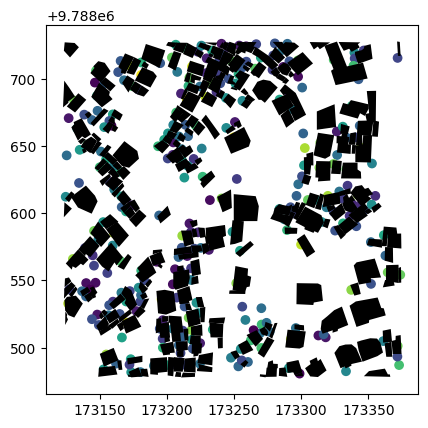

In [11]:
fig, ax = plt.subplots()
google_conf.plot(column = "confidence", ax=ax)
#model_conf.plot(column = "value", ax=ax)
gt.plot(ax=ax, color = "black")

### Calculate Cross Entropy Against Ground Truth

In [19]:
def ValArea_CrossEntropy(code, type = "model", filepath = "/content/drive/MyDrive/Building Footprints-Validation Areas/Shapefiles/"):
  year = code[:4]
  if type == "Google":
    df = pd.read_csv("/content/drive/MyDrive/Research/Morphology/Data/Building Footprints/Google Buildings Footprints/tmpv2fvxs5a", engine="c",
      usecols=['latitude', 'longitude', 'area_in_meters', 'confidence'])
    gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 4326).to_crs(32736)
  elif type == "model":
    pixel_df = gpd.read_parquet("/content/drive/MyDrive/Research/Morphology/Data/grid_dfs/"+year+"_conf_grid")

  loss = []
  for id in range(27):
    filename = filepath+city+"/"+year+"/Label_"+code+"_20"+str(id)+".shp"
    if os.path.isfile(filename):
      gt = gpd.read_file(filename).to_crs(crs)
      gt = gt[gt.geometry.type == 'Polygon'] #Only Keep Valid Polygon Geometry
      gt["value"]=1

      if type == "Google":
        model_conf = gdf[gdf.intersects(validation_gdf.loc[id,:].geometry)]
        model_conf['value'] = model_conf['confidence']
      elif type == "model":
        model_conf = pixel_df[pixel_df.intersects(validation_gdf.loc[id,:].geometry)]
        model_conf["value"] = model_conf["value"].fillna(0)
        model_conf["value"] = model_conf["value"]/100

      compare_built = gpd.overlay(gt, model_conf, how='intersection',keep_geom_type=False)
      compare_empty = gpd.overlay(model_conf, gt, how='difference',keep_geom_type=False)
      if compare_built.size!=0:
        #Clipped to avoid undefined at 0,1
        eps = 0.05
        #Both Built/Null Cross Entropy
        cross_entropy = -(np.log2(compare_built["value_2"].map(lambda x: max(eps,min(1 - eps, (x)))))).sum()-(np.log2(compare_empty["value"].map(lambda x: max(eps,min(1 - eps, (1-x)))))).sum()
        baseline = -(np.log2(compare_built["value_2"].map(lambda x: .5))).sum()-(np.log2(compare_empty["value"].map(lambda x: .5))).sum()
        cross_entropy = cross_entropy/baseline
        #Only Built Cross Entropy
        #cross_entropy = -(np.log2(compare_built["value_2"].map(lambda x: max(eps,min(1 - eps, (x)))))).sum()
        loss.append(cross_entropy)
      else:
        loss.append(np.nan)
    else:
      loss.append(np.nan)
  return loss

In [15]:
filepath =
dates = ["2006_0225", "2011_0620", "2012_0815", "2016_0516", "2017_0713", "2020_0802", "2022_0126"]
city = "Kigali"


performance = pd.DataFrame()
#for code in ["2006_0225", "2011_0620", "2017_0713", "2020_0802", "2022_0126"]:
for code in ["2022_0126"]:
  year = code[:4]
  performance[year] = ValArea_CrossEntropy(code, "google")

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

## Plotting

In [16]:
import seaborn as sns

In [17]:
perf_melt1 = performance.stack().reset_index().rename(columns = {"level_0":"zone", "level_1": "Year", 0: "Cross Entropy"})
perf_melt1["lcz"] = perf_melt1["zone"].map(val_lcz_dict)
perf_melt1["lcz_name"]= perf_melt1["lcz"].map(LCZ_dict[1])

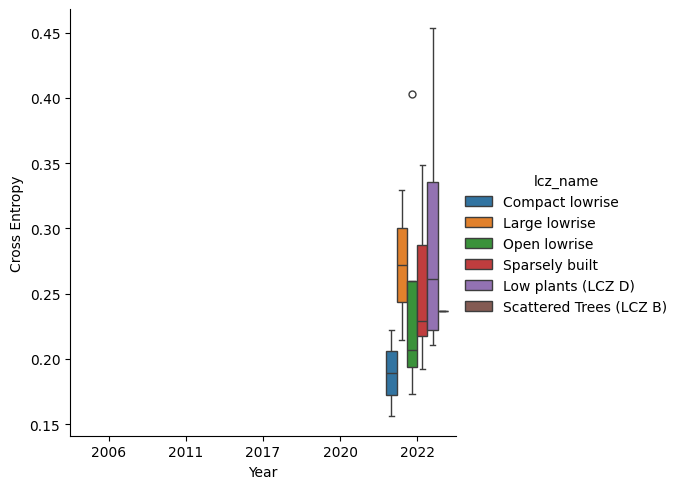

In [18]:
sns.catplot(data=perf_melt1, x="Year", y="Cross Entropy", hue="lcz_name", kind="box", order = ["2006", "2011", "2017", "2020", "2022"], hue_order=["Compact lowrise", "Large lowrise", "Open lowrise", "Sparsely built", "Low plants (LCZ D)", "Scattered Trees (LCZ B)"])